# Lyrics Emotions Project

## Our Data

Before doing anything with data, we need to import the necessary libraries to read and manipulate the data.

In [3]:
import pandas as pd

In [4]:
single_label = pd.read_csv('SingleLabel.csv', encoding='utf-8')
single_label.head()

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness


The above dataset contains several headers that give us information on the collected songs, such as the artist, genre, title, etc. The final column, "label", along with the "lyrics" column is to be used for the Classification problem.

In [5]:
multi_label = pd.read_csv('MultiLabel.csv', encoding='utf-8')
multi_label.head()

,artist,genre,title,album,year,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness"
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation"


This dataset contains the same information but differs in the final column, with it being labels and containing multiple labels for each example. This dataset is to be used for the Multi-Label Classification problem.

## Data Exploration and Preprocessing

### A: Classification

Let's take a look at the classes distribution, before transforming the data to model-interpretable format.

In [6]:
single_label['label'].value_counts()

Sadness       569
Tenderness    326
Tension       265
Name: label, dtype: int64

Sadness is the most represented class, with Tenderness and Tension following.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from statistics import mean
import nltk
from nltk.tokenize import RegexpTokenizer
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

After importing the neccessary libraries, we split the data in X and y (the "lyrics" data and the "label" data)

In [8]:
X = single_label['lyrics']
X.head()

0    I will never bother you\nI will never promise ...
1    Here we go\nMy big ego is gonna get me in trou...
2    She came as Lolita dressed as Venus\nAnd adorn...
3    Ivory Madonna, dying in the dust\nWaiting for ...
4    I was totin' my pack along the dusty Winnemucc...
Name: lyrics, dtype: object

In [9]:
y = single_label['label']
y.head()

0       Sadness
1       Tension
2    Tenderness
3       Sadness
4       Sadness
Name: label, dtype: object

In [42]:
def get_word_cloud(single_label):
    tokenizer = RegexpTokenizer("[\w']+")
    lines = single_label['lyrics'].map(tokenizer.tokenize)
    freq={}
    for line in lines:
        for word in line:
            if word.lower() not in freq:
                freq[word.lower()]=0
            freq[word.lower()]+=1
    wc = WordCloud(background_color="black",width=1000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=True).generate_from_frequencies(freq)
    plt.imshow(wc)

In [27]:
sadness = single_label[single_label['label']=='Sadness']
tenderness = single_label[single_label['label']=='Tenderness']
tension = single_label[single_label['label']=='Tension']

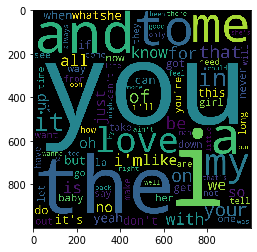

In [45]:
get_word_cloud(tenderness)

We then set up a TF/IDF Vectorizer to transform our lyrics into features that indicate their belonging to one of the three classes.

In [21]:
tfidf_vectors=[]
type={
    1:'unigram',
    2:'bigram',
    3:'trigram'
}
for i in range(1,4):
    for j in range(i,4):
        tfidf_vectors.append((type[i],type[j],TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(i,j),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")))

We then define our classifier as a LinearSVC and create a pipeline that first transforms the data and then feeds it into the Machine Learning classifier.

In [22]:
def get_pipeline_result(tfv, model,y_test):
    pipeline = make_pipeline(tfv, model)
    pipeline.fit(X_train, y_train)
    return accuracy_score(pipeline.predict(X_test),y_test)

def linear_svc(tfv,X_train,X_test,y_train,y_test):
    clf = LinearSVC(random_state=0)
    return get_pipeline_result(tfv, clf,y_test)

def rbf_svc(tfv,X_train,X_test,y_train,y_test):
    clf = SVC(kernel='rbf',gamma='scale')
    return get_pipeline_result(tfv, clf,y_test)

def knn(tfv,X_train,X_test,y_train,y_test,n):
    knn_classifier = KNeighborsClassifier(n_neighbors=n)
    return get_pipeline_result(tfv,knn_classifier,y_test)

def random_forest(tfv,X_train,X_test,y_train,y_test):
    rf = RandomForestClassifier(random_state=0,n_estimators = 100)
    return get_pipeline_result(tfv, rf,y_test)

def decision_tree(tfv,X_train,X_test,y_train,y_test):
    dt = DecisionTreeClassifier()
    return get_pipeline_result(tfv, dt,y_test)

def mlp_classifier(tfv,X_train,X_test,y_train,y_test,active_func=None):
    mlp = MLPClassifier(max_iter=1000,activation=active_func)
    return get_pipeline_result(tfv, mlp,y_test)

In [27]:
activations = ['logistic','relu','tanh']
overall_result = {
    'SVC-L':{},
    'SVC-R':{},
    'RF':{},
    'DT':{}
}
for i in range(3,10):
        overall_result['KNN-'+str(i)]={}
for activation in activations:
    overall_result['MLP-'+activation[0]]={}
bow = ['u + u', 'u + b','u + t','b + b','b + t','t + t']

for tfv_count in range(len(tfidf_vectors)):
    tfv = tfidf_vectors[tfv_count][2]
    results = {
        'SVC-L':[],
        'SVC-R':[],
        'RF':[],
        'DT':[]
    }
    for i in range(3,10):
        results['KNN-'+str(i)]=[]
    for activation in activations:
        results['MLP-'+activation[0]]=[]
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
        results['SVC-L'].append(linear_svc(tfv,X_train, X_test, y_train,y_test))
        results['SVC-R'].append(rbf_svc(tfv,X_train, X_test, y_train,y_test))
        for i in range(3,10):
            results['KNN-'+str(i)].append(knn(tfv,X_train, X_test, y_train,y_test,i))
        results['RF'].append(random_forest(tfv,X_train, X_test, y_train,y_test))
        results['DT'].append(decision_tree(tfv,X_train, X_test, y_train,y_test))
        for activation in activations:
            results['MLP-'+activation[0]].append(mlp_classifier(tfv,X_train, X_test, y_train,y_test,activation))
    for result in results:
        overall_result[result][tfidf_vectors[tfv_count][0][0]+' + '+tfidf_vectors[tfv_count][1][0]]=round(mean(results[result])*100,2)
        
print('Model\t',end='')
for name in bow:
    print(name+'\t',sep='',end='')
print('')
for model in overall_result:
    print(model+'\t',sep='',end='')
    for name in bow:
        print(str(overall_result[model][name])+'\t',sep='',end='')
    print('')

Model	u + u	u + b	u + t	b + b	b + t	t + t	
SVC-L	61.03	60.69	60.34	53.45	52.76	50.69	
SVC-R	61.72	61.03	61.03	54.48	53.79	50.0	
RF	61.03	62.41	60.0	55.86	54.14	50.0	
DT	51.03	51.79	49.34	48.93	49.34	50.24	
KNN-3	54.48	53.79	53.45	51.03	51.03	50.34	
KNN-4	50.69	55.52	53.45	43.1	42.41	49.66	
KNN-5	51.72	54.14	53.79	45.17	44.14	50.69	
KNN-6	53.1	55.17	56.55	44.48	44.83	50.0	
KNN-7	53.79	54.83	54.48	45.52	43.45	52.76	
KNN-8	54.14	56.9	56.9	48.62	43.45	52.07	
KNN-9	53.79	58.28	57.93	48.28	47.59	52.76	
MLP-l	60.14	56.66	55.79	52.14	52.1	50.31	
MLP-r	59.41	57.59	55.83	52.83	51.66	50.1	
MLP-t	59.62	56.62	55.66	52.59	52.21	50.31	


### B: Multi-Label Classification

First we are going to take a look at the distribution of labels in our dataset.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '))
emotion_dtm = vectorizer.fit_transform(multi_label['labels'])
print('Number of data points:', emotion_dtm.shape[0])
print('Number of unique emotions:', emotion_dtm.shape[1])

In [ ]:
emotions = vectorizer.get_feature_names()
freqs = emotion_dtm.sum(axis=0).A1
result = dict(zip(emotions, freqs))
print(result.items())
freq_count = pd.DataFrame(list(result.items()), columns=['Emotions', 'Counts'])
freq_sorted = freq_count.sort_values(['Counts'], ascending=False)
freq_sorted

In [ ]:
emotion_per_example = emotion_dtm.sum(axis=1).tolist()
emotion_per_example = [int(j) for i in emotion_per_example for j in i]
print('Maximum emotions per example: %d'%max(emotion_per_example))
print('Minimum emotions per example: %d'%min(emotion_per_example))
print('Average emotions per example: %f'% ((sum(emotion_per_example))/len(emotion_per_example)))

After taking a closer look at the data in hand, we proceed with solving the classification problem.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

For this task we will need a Binarizer for the labels. As each example is annotated as more than one classes, we need to transform this information to a machine-readable format. But first, let's create X and y.

In [ ]:
X = multi_label['lyrics']
X.head()

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(multi_label['labels'])
y

In the line above, our labels are transformed into arrays, where 1 indicates the presence of a specific class.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

For this problem we are using Logistic Regression-trained classifiers for each class, with the help of the OneVsRestClassifier. The data is again fed into the classifier via a pipeline, where it is transformed into vectors of TF/IDF features.

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
pipeline = make_pipeline(tfv, clf)

Now, that we have our model, we once again split into training and test sets to calculate our classifier's efficiency in classifying lyrics into sets of emotions' labels.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Before we fit our classifiers, we import the f1-score metric to evaluate the efficiency of learning of our model.

In [ ]:
from sklearn.metrics import f1_score

This time the average setting of f1_score is set to micro in order to aggregate the contributions of all classes and compute the average metric.

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('F1-SCORE :',f1_score(y_test, y_pred, average="micro"))